### Importing key libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Set seeds for reproducibility
import random
random.seed(42)
tf.random.set_seed(42)

2025-06-25 21:54:37.487446: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 21:54:37.506402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750906477.516310  572850 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750906477.519482  572850 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750906477.528917  572850 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
session = tf.compat.v1.Session(config=config)

I0000 00:00:1750906481.572674  572850 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


### Hyperparameters

In [16]:
IMG_SIZE = 224
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
NUM_EPOCHS = 60
# EarlyStopping
PATIENCE = 5 # no. of epochs with no improvement after which training will be stopped
# ReduceLROnPlateau
LR_PATIENCE = 5 # no. of epochs with no improvement after which learning rate will be reduced
LR_FACTOR = 0.1 # factor by which the learning rate will be reduced
MIN_LR = 1e-6 # lower bound on the learning rate

### Dataset splitting

In [ ]:
!pip install -q split-folders

In [5]:
import splitfolders

dataset_dir = r'dataset'
output_dir = r'splitted_data'

# Make output dir if doesn't exist, else skip
os.makedirs(output_dir, exist_ok=True)

splitfolders.ratio(dataset_dir, output=output_dir, seed=1337, ratio=(0.75, 0.15, 0.1))
print(f"Dataset successfully splitted into: {os.listdir(output_dir)}")

Copying files: 41793 files [00:04, 8522.39 files/s]

Dataset successfully splitted into: ['test', 'val', 'train']


### Dataset config

In [6]:
def helper_ds(partition, shuffle_status=True):
    return tf.keras.utils.image_dataset_from_directory(
        directory=os.path.join(output_dir, partition),
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        seed=1337,
        labels='inferred',
        label_mode='binary',
        shuffle=shuffle_status
    )

train_ds = helper_ds('train')
test_ds = helper_ds('test', shuffle_status=False)
val_ds = helper_ds('val')

Found 31344 files belonging to 2 classes.


I0000 00:00:1750906500.551211  572850 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 4181 files belonging to 2 classes.
Found 6268 files belonging to 2 classes.


### Data visualization

2025-06-25 21:55:02.616963: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


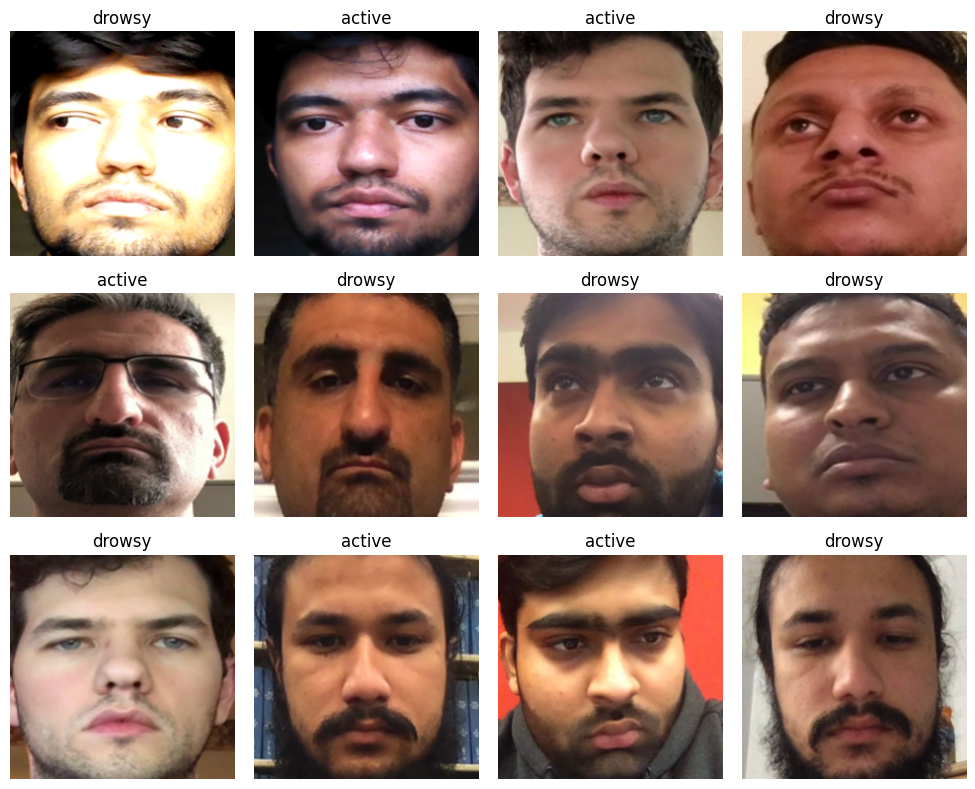

In [7]:
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        state = "active" if int(labels[i]) else "drowsy"
        plt.title(state)
        plt.axis("off")
        plt.tight_layout()

In [8]:
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Class names: ['Drowsy', 'Non Drowsy']


### Data augmentation example

/home/oran-testbed/miniconda3/envs/.tf/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-06-25 21:55:06.670805: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


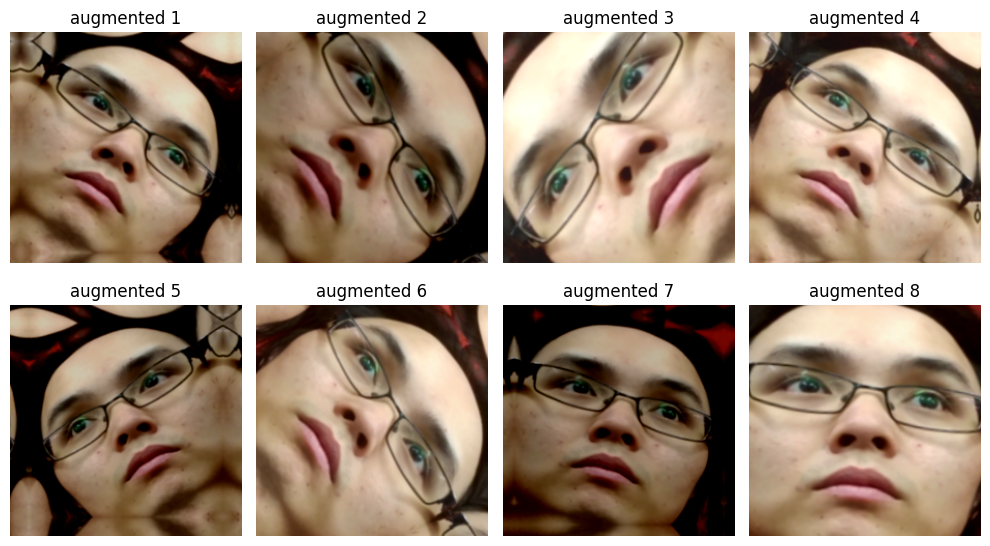

In [9]:
data_aug = [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness([-0.3, 0.1])
]

def data_augmentation(images):
    for layer in data_aug:
        images = layer(images)
    return images

plt.figure(figsize=(10, 6))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.title(f"augmented {i+1}")
        plt.axis("off")
        plt.tight_layout()

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

# Normalize pixel values
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# Enable prefetching and shuffling
train_ds = train_ds.shuffle(buffer_size=10000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
# Retain class names after applying map
train_ds.class_names = class_names
print(train_ds.class_names)

['Drowsy', 'Non Drowsy']


In [12]:
# Double checking if train_ds exists and has class_names
if hasattr(train_ds, 'class_names'):
    print("Class Names:", train_ds.class_names)
else:
    print("Error: train_ds does not have class_names. Verify dataset creation.")

Class Names: ['Drowsy', 'Non Drowsy']


### Stacking models

In [13]:
def stacked_model(input_shape=[IMG_SIZE, IMG_SIZE, 3]):

    d_net = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    e_net = tf.keras.applications.EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=input_shape)
    m_net = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the models
    d_net.trainable=False; e_net.trainable=False; m_net.trainable=False

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Data augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness([-0.3, 0.1])
    ])

    augmented_inputs = data_augmentation(inputs)

    # Extracted features
    d_net_features = d_net(augmented_inputs)
    e_net_features = e_net(augmented_inputs)
    m_net_features = m_net(augmented_inputs)

    # Global average pooling
    d_net_pooling = tf.keras.layers.GlobalAveragePooling2D()(d_net_features)
    e_net_pooling = tf.keras.layers.GlobalAveragePooling2D()(e_net_features)
    m_net_pooling = tf.keras.layers.GlobalAveragePooling2D()(m_net_features)

    # Combine outputs
    combined_outputs = tf.keras.layers.concatenate([d_net_pooling, e_net_pooling])
    # REFERENCE: https://stackoverflow.com/a/71170687/23011800
    outputs_pre = tf.keras.layers.Dense(1024, activation='relu')(combined_outputs)
    outputs_pre = tf.keras.layers.Dropout(DROPOUT_RATE)(outputs_pre)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs_pre)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

### Defining callbacks

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=MIN_LR)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoints/best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

# Custom training curve callback
from IPython.display import clear_output

train_losses=[]; val_losses=[]; precision_scores=[]; recall_scores=[]

class TrainingCurveCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_losses.append(logs['loss'])
        val_losses.append(logs['val_loss'])
        precision_scores.append(logs['precision'])
        recall_scores.append(logs['recall'])

        clear_output(wait=True) # clear output before plotting

        fig, ax1 = plt.subplots(figsize=(10, 5)) # create figure; will contain loss/accuracy curves
        fig.suptitle('Training Curves')

        # loss curve (ax1 - left y axis)
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_xlim(left=0)
        ax1.set_ylabel('Loss function')

        # determine left y axis range from min/max loss values
        y_ax1_min = min(min(train_losses), min(val_losses)) # find lowest loss value across both curves
        y_ax1_min = max(0, y_ax1_min - 0.1) # add some padding to the bottom of the plot. lower bound can't be less than 0
        y_ax1_max = max(max(train_losses), max(val_losses)) + 0.1# find highest loss value across both curves, add some padding to the top of the plot
        ax1.set_ylim(y_ax1_min, y_ax1_max) # set y axis limits

        # Best epoch (smallest loss)
        best_epoch = int(np.argmin(train_losses))
        best_loss = train_losses[best_epoch]

        # add veritcal line for best epoch
        ax1.vlines(best_epoch, ymin=y_ax1_min, ymax=y_ax1_max, linestyles='dashed', colors='black',
                   label=f'best epoch={best_epoch}\nloss={best_loss:.3f}')
        ax1.legend(loc='upper left')

        # create right y axis for precision/recall curves
        ax2 = ax1.twinx()

        # Plot precision/recall (right y-axis)
        ax2.plot(precision_scores, label=f'Precision\n{precision_scores[best_epoch]:.3f} @ {best_epoch}', color='red')
        ax2.plot(recall_scores, label=f'Recall\n{recall_scores[best_epoch]:.3f} @ {best_epoch}', color='green')
        ax2.set_ylabel('Precision / Recall')
        ax2.set_ylim(0, 1)
        ax2.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

### Initializing the model

In [15]:
ensemble_model = stacked_model()

### Model summary (optional)

In [ ]:
# ensemble_model.summary()

### Training the model

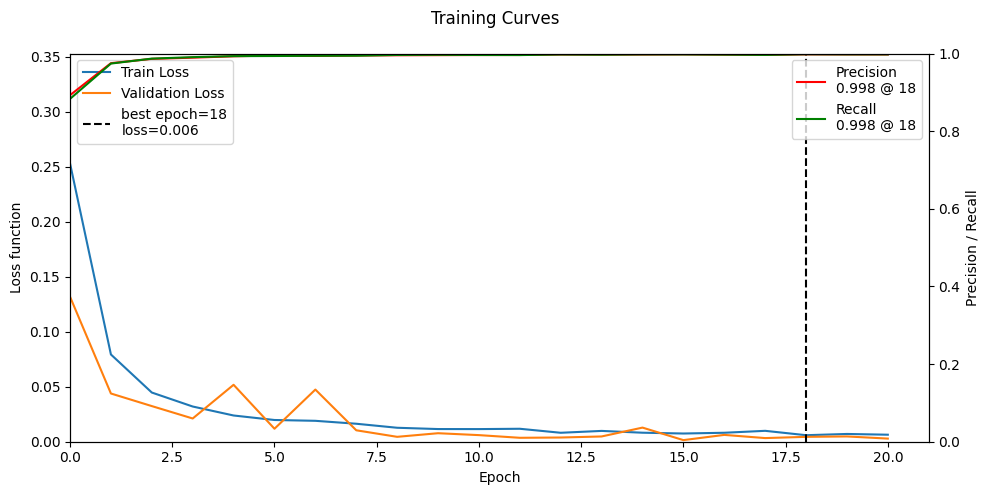

980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9974 - auc: 0.9999 - loss: 0.0070 - precision: 0.9967 - recall: 0.9977 - val_accuracy: 0.9992 - val_auc: 1.0000 - val_loss: 0.0029 - val_precision: 0.9990 - val_recall: 0.9993 - learning_rate: 1.0000e-04


In [17]:
history = ensemble_model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS,
                             callbacks=[early_stopping, lr_scheduler, model_checkpoint, TrainingCurveCallback()], shuffle=True)

In [27]:
ensemble_model.save('ensemble.keras')
print("Model saved!")

Model saved!


In [31]:
trained_ensemble = tf.keras.models.load_model('ensemble.keras')
test_val_loss, test_val_accuracy, *rest = trained_ensemble.evaluate(val_ds)
print(f"Ensemble Model - Validation Loss: {test_val_loss:.5f}, Validation Accuracy: {test_val_accuracy:.5f}")

196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0015 - precision: 1.0000 - recall: 1.0000
Ensemble Model - Validation Loss: 0.00145, Validation Accuracy: 1.00000


### Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

<Figure size 800x800 with 0 Axes>

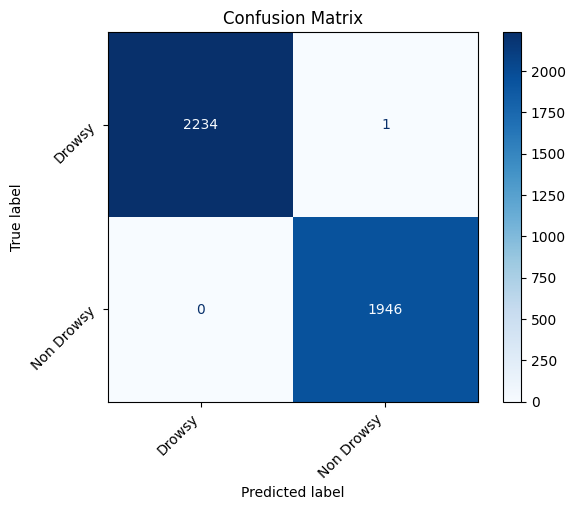

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = []; y_true = []

# Collecting predictions and true labels
for images, labels in test_ds:
    preds = ensemble_model.predict(images)
    y_pred.extend(np.round(preds))
    y_true.extend(labels.numpy())

# Computing confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.yticks(rotation=45, ha='right')
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.show()